In [1]:
import sys
sys.path.append("../data/saved_models/")
sys.path.append("../model_scripts/")
sys.path.append("../utils/")
import os
import json

import numpy as np
import torch

import matplotlib.pyplot as plt
import fig4_plots

import fig4_analysis as rnn
import basic_analysis as basic
import model_utils
from task import generate_batch

import scipy
from scipy import stats
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
from scipy.spatial import distance as dist

In [2]:
# file paths
data_folder = f"../data/saved_models/1d_3map/"
save_folder = f"../figures/fig4_plots/"

if os.path.isdir(save_folder):
    print('save folder exists')
else:
    os.mkdir(save_folder)
    
# font sizes
title_size = 10

save folder exists


In [3]:
# get the model IDs for all saved models
model_IDs = os.listdir(data_folder)

# select example model
ex_id = 0
model_ID = model_IDs[ex_id]

In [4]:
# get sample rnn data
inputs, outputs, targets = model_utils.sample_rnn_data(data_folder, model_ID)
X, map_targ, pos_targ = model_utils.format_rnn_data(outputs["hidden_states"],\
                                                    targets["map_targets"],\
                                                    targets["pos_targets"])

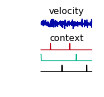

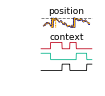

In [5]:
''' Figure 4A: model schematic '''
f, gs = fig4_plots.plot_a1(inputs["inp_vel"],\
                          inputs["inp_remaps"])
plt.show()
f.savefig(f'{save_folder}inputs.png', dpi=600, bbox_inches='tight')

f, gs = fig4_plots.plot_a2(targets["pos_targets"],\
                          outputs["pos_outputs"],\
                          outputs["map_logits"])
plt.show()
f.savefig(f'{save_folder}outputs.png', dpi=600, bbox_inches='tight')

mean +/- standard error of the mean:
position loss: 0.0132 +/- 0.000356
context loss: 0.00385 +/- 4.86e-05


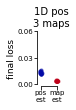

In [6]:
''' summary performance across models '''
f, ax = fig4_plots.plot_supp_1(data_folder, model_IDs)
ax.set_title('1D pos\n3 maps', fontsize=title_size, pad=5)
plt.show()

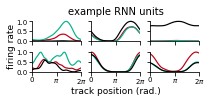

In [10]:
''' Figure 4B: example tuning '''
f, axes = fig4_plots.plot_b(X, map_targ, pos_targ)
plt.show()
f.savefig(f'{save_folder}ex_tuning.png', dpi=600, bbox_inches='tight')

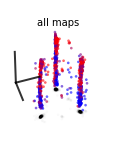

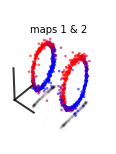

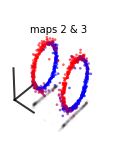

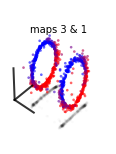

In [12]:
''' Figure 4C: aligned ring manifolds '''
f, ax = fig4_plots.plot_c(X, pos_targ)
ax.set_title('all maps',
             fontsize=title_size, pad=5)

ax.view_init(azim=160, elev=30)
plt.show()
f.savefig(f'{save_folder}manifolds.png', dpi=600, bbox_inches='tight')

n_maps = np.max(np.unique(map_targ)) + 1
for j in range(n_maps):
    m0_id = j
    m1_id = (j+1)%n_maps
    map_idx = (map_targ==m0_id) | (map_targ==m1_id)
    f, ax = fig4_plots.plot_c(X[map_idx], pos_targ[map_idx])
    ax.set_title(f'maps {m0_id+1} & {m1_id+1}',
                 fontsize=title_size, pad=-2)
    plt.show()
    f.savefig(f'{save_folder}manifolds_{m0_id+1}{m1_id+1}.png', dpi=600, bbox_inches='tight')

In [4]:
''' Figure 4D: angle between remapping dimensions '''
rnn.align_remap_dims(data_folder, model_IDs)

angle between remapping dims (mean, sem) = 60 deg., 0.0006 deg.


on average, 4 PCs explain 63.69% of the variance
on average, 14 PCs explain 90.55% of the variance
on average, 3 PCs explain 66.77% of the variance within each map


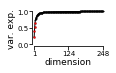

In [8]:
''' Figure 4E: summary of dimensionality '''
f, axes = fig4_plots.plot_d(data_folder, model_IDs, top_num_1=3)
plt.show()
f.savefig(f'{save_folder}PCs_all.png', dpi=600, bbox_inches='tight')

mean misalignment = 0.49
sem misalignment = 0.0054


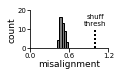

In [4]:
''' Figure 4F: summary of ring alignment '''
f, ax = fig4_plots.plot_e(data_folder, model_IDs)
f.savefig(f'{save_folder}alignment.png', dpi=600, bbox_inches='tight')
plt.show()

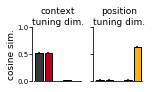

In [5]:
''' Figure 4G: alignment to remapping dim and position subspace '''
f, ax = fig4_plots.plot_g(data_folder, model_IDs)
plt.show()
f.savefig(f'{save_folder}dim_angles.png', dpi=600, bbox_inches='tight')